In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine
import warnings
import json
import pickle
import os
import sys
import gc
import xgboost as xgb

warnings.filterwarnings('ignore')

In [2]:
def get_models(initial_path):
    models = {}
    for inv_dir in os.listdir(initial_path):
        if ("inversor" in inv_dir.lower()) & (os.path.isdir(os.path.join(initial_path, inv_dir))):
            explotacion_path = os.path.join(initial_path, inv_dir, "Explotacion")
            for model_dir in os.listdir(explotacion_path):
                model_path = os.path.join(explotacion_path, model_dir)
                if os.path.isdir(model_path):
                    model_dict = {}
                    with open(os.path.join(model_path, "model.model"), "rb") as f:
                        model_dict["model"] = pickle.load(f)
                    with open(os.path.join(model_path, "informe_modelo.json"), "r") as f:
                        informe_modelo = json.load(f)
                        model_dict["intervalo"] = informe_modelo["intervalo_min"]
                        model_dict["normalizacion"] = informe_modelo["normalizacion"]
                        model_dict["RMSE"] = informe_modelo["metricas"]["RMSE"]
                    models[inv_dir] = model_dict
    return models

In [4]:
root_path = "/home/upo/Desktop/Test_FVPredictive/FVPredictive_TEST/Galisteo"
params = None
for filename in os.listdir(root_path):
    if "params.json" in filename:
        with open(os.path.join(root_path, filename)) as f:
            params = json.load(f)
if params is None:
    print("No se ha encontrado el archivo de parámetros para la conexión a la base de datos")
    sys.exit()
data_path = os.path.join(root_path, params["data_path"])
schema_name = params["schema"]

password = params['password'].replace('@', '%40')
engine = create_engine(f'postgresql://{params["user"]}:{password}@{params["host"]}:{params["port"]}/{params["dbname"]}')
print(f"Conexión a la base de datos {params['dbname']} (esquema {schema_name}) establecida")

Conexión a la base de datos fvpredictive (esquema galisteo) establecida


In [5]:
model_path = os.path.join(root_path, "Modelos", "potencia_inversor")
models_dict = get_models(model_path)

In [6]:
for inv in models_dict:
    dispositivo_id = int(inv.split("_")[1]) + 20
    intervalo = models_dict[inv]["intervalo"]
    normalizacion = models_dict[inv]["normalizacion"]
    main_query = f"""
        WITH inv AS (
            SELECT 
                date_trunc('hour', datetime_utc) + 
                INTERVAL '{intervalo} min' * floor(date_part('minute', datetime_utc) / {intervalo}) as datetime_utc_rounded,
                dispositivo_id,
                MIN(inv.id) AS id, 
                AVG(potencia_act) as potencia_act
            FROM {schema_name}.inversores AS inv
            WHERE dispositivo_id = {dispositivo_id}
            GROUP BY datetime_utc_rounded, dispositivo_id 
        ),
        met AS (
            SELECT 
                date_trunc('hour', datetime_utc) + 
                INTERVAL '{intervalo} min' * floor(date_part('minute', datetime_utc) / {intervalo}) as datetime_utc_rounded, 
                dispositivo_id,
                AVG(rad_poa) AS rad_poa, 
                AVG(rad_hor) AS rad_hor, 
                AVG(rad_celda1) AS rad_celda1,
                AVG(rad_celda2) AS rad_celda2, 
                AVG(temp_amb) AS temp_amb, 
                AVG(temp_panel1) AS temp_panel1,
                AVG(temp_panel2) AS temp_panel2, 
                AVG(cloud_impact) AS cloud_impact,
                BOOL_OR(daylight) AS daylight
            FROM {schema_name}.meteo
                WHERE daylight = true
            GROUP BY dispositivo_id, datetime_utc_rounded
        )
        SELECT 
            inv.id,
            inv.dispositivo_id,
            inv.datetime_utc_rounded as datetime_utc, 
            potencia_act,
            rad_poa,
            rad_hor, 
            rad_celda1, 
            rad_celda2, 
            temp_amb, 
            temp_panel1, 
            temp_panel2,
            cloud_impact,
            motivo,
            consigna_pot_act_planta
        FROM inv
        JOIN {schema_name}.dispositivos AS disp
            ON disp.dispositivo_id = inv.dispositivo_id
        JOIN met
            ON met.datetime_utc_rounded = inv.datetime_utc_rounded
                AND met.dispositivo_id = disp.meteo_cercana_id
        JOIN {schema_name}.ree AS ree
            ON ree.datetime_utc = inv.datetime_utc_rounded
        ORDER BY 5, 2, 3, 4;"""

    chunksize = 100000
    chunks = pd.read_sql_query(main_query, engine, chunksize=chunksize)
    main_df = pd.DataFrame()
    for chunk in chunks:
        main_df = pd.concat([main_df, chunk], ignore_index = True)
    del chunks, chunk
    gc.collect()

In [7]:
main_df

,id,dispositivo_id,datetime_utc,potencia_act,rad_poa,rad_hor,rad_celda1,rad_celda2,temp_amb,temp_panel1,temp_panel2,cloud_impact,motivo,consigna_pot_act_planta
0,3625470,21,2023-07-07 09:00:00+02:00,2416.000000,0.000000,314.183332,761.963332,760.930001,21.310000,37.666667,36.866667,100.000000,7,38.7
1,3625860,21,2023-07-07 09:15:00+02:00,2561.266667,0.000000,359.800000,809.139998,807.863334,20.740000,40.413333,39.926667,100.000000,7,38.7
2,18457396,21,2022-11-08 18:15:00+01:00,0.000000,0.850000,0.525000,5.425000,4.600000,16.299999,16.600000,26.600000,100.000000,0,38.7
3,6338690,21,2023-09-17 20:30:00+02:00,0.000000,0.900000,0.583333,5.366667,4.516667,18.516667,18.550000,17.450000,100.000000,0,38.7
4,2192054,21,2023-05-29 21:45:00+02:00,0.000000,0.950000,0.750000,5.500000,4.600000,15.525000,16.324999,15.450000,100.000000,0,38.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26802,12504136,21,2022-06-02 12:45:00+02:00,3159.000000,1206.693341,1153.750006,1145.293333,1129.503333,24.023333,40.453333,41.906667,105.582938,0,38.7
26803,10564910,21,2022-04-11 12:00:00+02:00,3193.266667,1218.200012,1065.009996,1188.363340,1187.100006,18.346667,34.840001,35.030000,119.725412,0,38.7
26804,2737438,21,2023-06-13 11:30:00+02:00,2767.666667,1223.276660,1057.149990,1191.073338,1192.110004,22.086667,49.703333,48.903333,103.301456,0,38.7
26805,2218574,21,2023-05-30 14:45:00+02:00,3394.566667,1232.836658,1232.976658,1214.706669,1212.700002,21.866667,47.686667,47.200000,94.083577,0,38.7


In [8]:
# Normalización de la entrada de corriente continua, formateo de fechas y escalado de potencia
print(f"\tCarga inicial de {main_df.shape[0]} registros")
main_df["datetime_utc"] = pd.to_datetime(main_df["datetime_utc"], utc = True)
main_df["potencia_act"] = main_df["potencia_act"] * 1000

	Carga inicial de 26807 registros


In [9]:
# Manipulación de variables meteorológicas
main_df["rad_diff"] = (main_df["rad_celda1"] - main_df["rad_celda2"])
main_df["temp_panel"] = (main_df["temp_panel1"] + main_df["temp_panel2"]) / 2
main_df = main_df.drop(columns = ["rad_celda1", "rad_celda2", "temp_panel1", "temp_panel2"])

In [10]:
# Manipulación de variables de consigna
main_query = f"""
    SELECT MAX(consigna_pot_act_planta)
        FROM {schema_name}.ree AS ree;"""
max_pot_act = pd.read_sql_query(main_query, engine).values[0][0]
main_df["consigna_pot_act_planta"] = main_df["consigna_pot_act_planta"] / max_pot_act 

In [11]:
# Asignación de variables temporales
main_df["dia_año"] = main_df["datetime_utc"].dt.dayofyear
main_df["dia_año_sen"] = np.sin(main_df["dia_año"] * (2*np.pi/365))
main_df["hora_seg"] = main_df["datetime_utc"].dt.hour * 3600 + \
                        main_df["datetime_utc"].dt.minute * 60 + \
                        main_df["datetime_utc"].dt.second
main_df["hora_seg_sen"] = np.sin(main_df["hora_seg"] * (2*np.pi/86400))

In [12]:
# Escalado de variables porcentuales
main_df[['cloud_impact']] = main_df[['cloud_impact']].apply(lambda x: x/100)

In [13]:
processed_df = main_df.drop(columns = ["id",
                "dia_año",
                "hora_seg"
                ]).set_index(["datetime_utc",
                                "dispositivo_id"])
y = processed_df[["potencia_act"]]
X = processed_df.drop(columns = ["potencia_act"])
X_prep = models_dict[inv]["model"].named_steps["preprocessor"].transform(X)
dtrain = xgb.DMatrix(X_prep)
y_pred = models_dict[inv]["model"].named_steps["regressor"].predict(dtrain)

In [14]:
target_df = y.copy()
target_df["pred"] = y_pred
target_df["diff"] = target_df["potencia_act"] - target_df["pred"]

In [15]:
lower_lim = models_dict[inv]["RMSE"]
upper_lim = 3 * models_dict[inv]["RMSE"]

In [16]:
target_df.reset_index(inplace = True)

In [17]:
target_df

,datetime_utc,dispositivo_id,potencia_act,pred,diff
0,2023-07-07 07:00:00+00:00,21,2.416000e+06,347514.625,2.068485e+06
1,2023-07-07 07:15:00+00:00,21,2.561267e+06,347514.625,2.213752e+06
2,2022-11-08 17:15:00+00:00,21,0.000000e+00,95144.500,-9.514450e+04
3,2023-09-17 18:30:00+00:00,21,0.000000e+00,99151.875,-9.915188e+04
4,2023-05-29 19:45:00+00:00,21,0.000000e+00,95144.500,-9.514450e+04
...,...,...,...,...,...
26802,2022-06-02 10:45:00+00:00,21,3.159000e+06,2971041.000,1.879590e+05
26803,2022-04-11 10:00:00+00:00,21,3.193267e+06,2986640.000,2.066267e+05
26804,2023-06-13 09:30:00+00:00,21,2.767667e+06,2943970.000,-1.763033e+05
26805,2023-05-30 12:45:00+00:00,21,3.394567e+06,2919746.500,4.748202e+05


### PROMEDIADO DIARIO

In [18]:
daily_df = target_df.resample("D", on = "datetime_utc").mean().drop(columns = "dispositivo_id").reset_index()

In [19]:
daily_df["date"] = daily_df["datetime_utc"].dt.date
daily_df["date"] = pd.to_datetime(daily_df["date"])
daily_df

,datetime_utc,potencia_act,pred,diff,date
0,2022-01-01 00:00:00+00:00,8.135360e+05,1.175733e+06,-362196.961075,2022-01-01
1,2022-01-02 00:00:00+00:00,7.757132e+05,1.126892e+06,-351178.631579,2022-01-02
2,2022-01-03 00:00:00+00:00,8.148737e+05,1.221720e+06,-406846.675987,2022-01-03
3,2022-01-04 00:00:00+00:00,NaN,NaN,NaN,2022-01-04
4,2022-01-05 00:00:00+00:00,3.615111e+05,6.593944e+05,-297883.297543,2022-01-05
...,...,...,...,...,...
633,2023-09-26 00:00:00+00:00,1.983247e+06,1.970202e+06,13045.308673,2023-09-26
634,2023-09-27 00:00:00+00:00,1.896999e+06,1.896018e+06,981.318387,2023-09-27
635,2023-09-28 00:00:00+00:00,1.623911e+06,1.626964e+06,-3052.327691,2023-09-28
636,2023-09-29 00:00:00+00:00,1.718377e+06,1.740500e+06,-22122.802083,2023-09-29


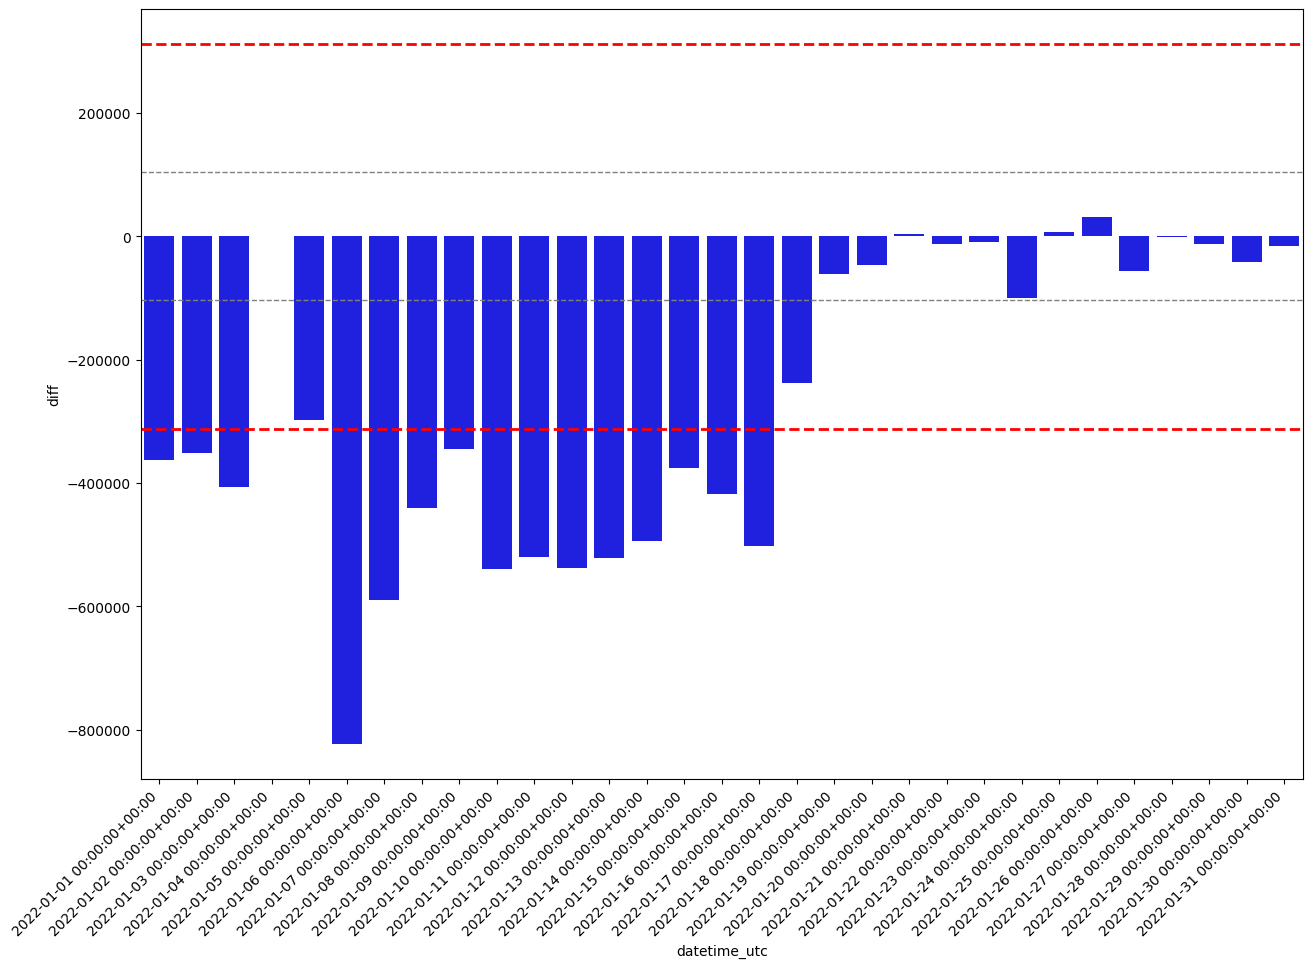

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(daily_df[(daily_df["datetime_utc"].dt.month == 1) & (daily_df["datetime_utc"].dt.year == 2022)], x="datetime_utc", y="diff", ax=ax, color="blue")

plt.xticks(rotation=45, ha='right')  # Girar las etiquetas al final de la cadena

# Add horizontal dashed lines at +- lower_lim
ax.axhline(y=-lower_lim, linestyle='--', color='gray', linewidth=1)
ax.axhline(y=lower_lim, linestyle='--', color='gray', linewidth=1)

# Add thicker red dashed lines at +- upper_lim
ax.axhline(y=-upper_lim, linestyle='--', color='red', linewidth=2)
ax.axhline(y=upper_lim, linestyle='--', color='red', linewidth=2)

plt.show()


In [21]:
fallos_df = pd.read_csv('/home/upo/Desktop/Test_FVPredictive/FVPredictive_TEST/Galisteo/Datos/Nuevos/Historico alarmas galisteo 04_05_2023.csv', sep=';')
fallos_df["inversor"] = fallos_df["Equipment"].str.split(".").str[1]
fallos_df["fallo"] = fallos_df["Equipment"].str.split(".").str[2]
fallos_df = fallos_df[fallos_df["inversor"] == "INVERSOR_01"]
fallos_df = fallos_df[["inversor", "fallo", "NAME", "OnDate", "OnTime", "OffDate", "OffTime"]]
fallos_df['OnDate'] = pd.to_datetime(fallos_df['OnDate'])

daily_fallos_df = pd.merge(daily_df, fallos_df, left_on = 'date', right_on = 'OnDate', how = 'outer')
daily_fallos_df["soft_lim"] = np.abs(daily_fallos_df["diff"]) > lower_lim
daily_fallos_df["hard_lim"] = np.abs(daily_fallos_df["diff"]) > upper_lim

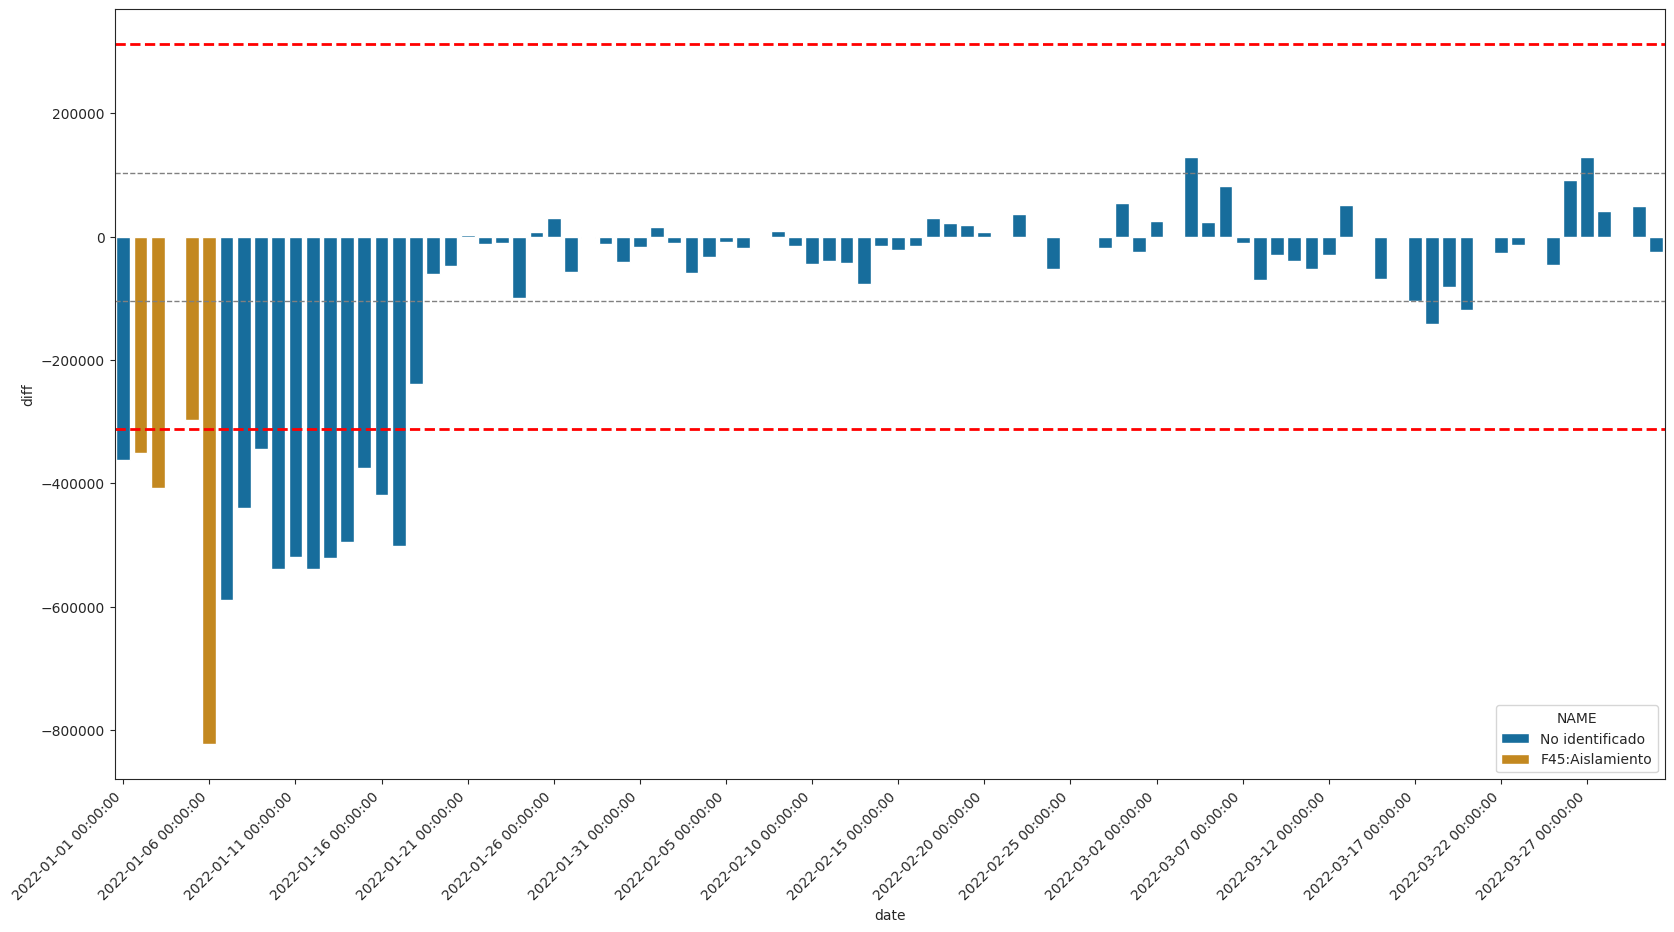

In [70]:
import seaborn as sns

# Set the style to have a smooth vertical grid
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(20, 10))
daily_fallos_df["NAME"] = daily_fallos_df["NAME"].fillna("No identificado")
filtered_df = daily_fallos_df[((daily_fallos_df["datetime_utc"].dt.month == 1) |
                               (daily_fallos_df["datetime_utc"].dt.month == 2) |
                               (daily_fallos_df["datetime_utc"].dt.month == 3)) &
                             (daily_fallos_df["datetime_utc"].dt.year == 2022)].drop_duplicates(subset = ["date", "NAME"])
sns.barplot(filtered_df, 
            x="date", 
            y="diff", 
            hue="NAME",
            ax=ax,
            dodge = False,
            palette = "colorblind")

# Set the x-axis labels to display every week
ax.xaxis.set_major_locator(plt.MaxNLocator(filtered_df.shape[0]//5))
plt.xticks(rotation=45, ha='right')

# Add horizontal dashed lines at +- lower_lim
ax.axhline(y=-lower_lim, linestyle='--', color='gray', linewidth=1)
ax.axhline(y=lower_lim, linestyle='--', color='gray', linewidth=1)

# Add thicker red dashed lines at +- upper_lim
ax.axhline(y=-upper_lim, linestyle='--', color='red', linewidth=2)
ax.axhline(y=upper_lim, linestyle='--', color='red', linewidth=2)

plt.show()

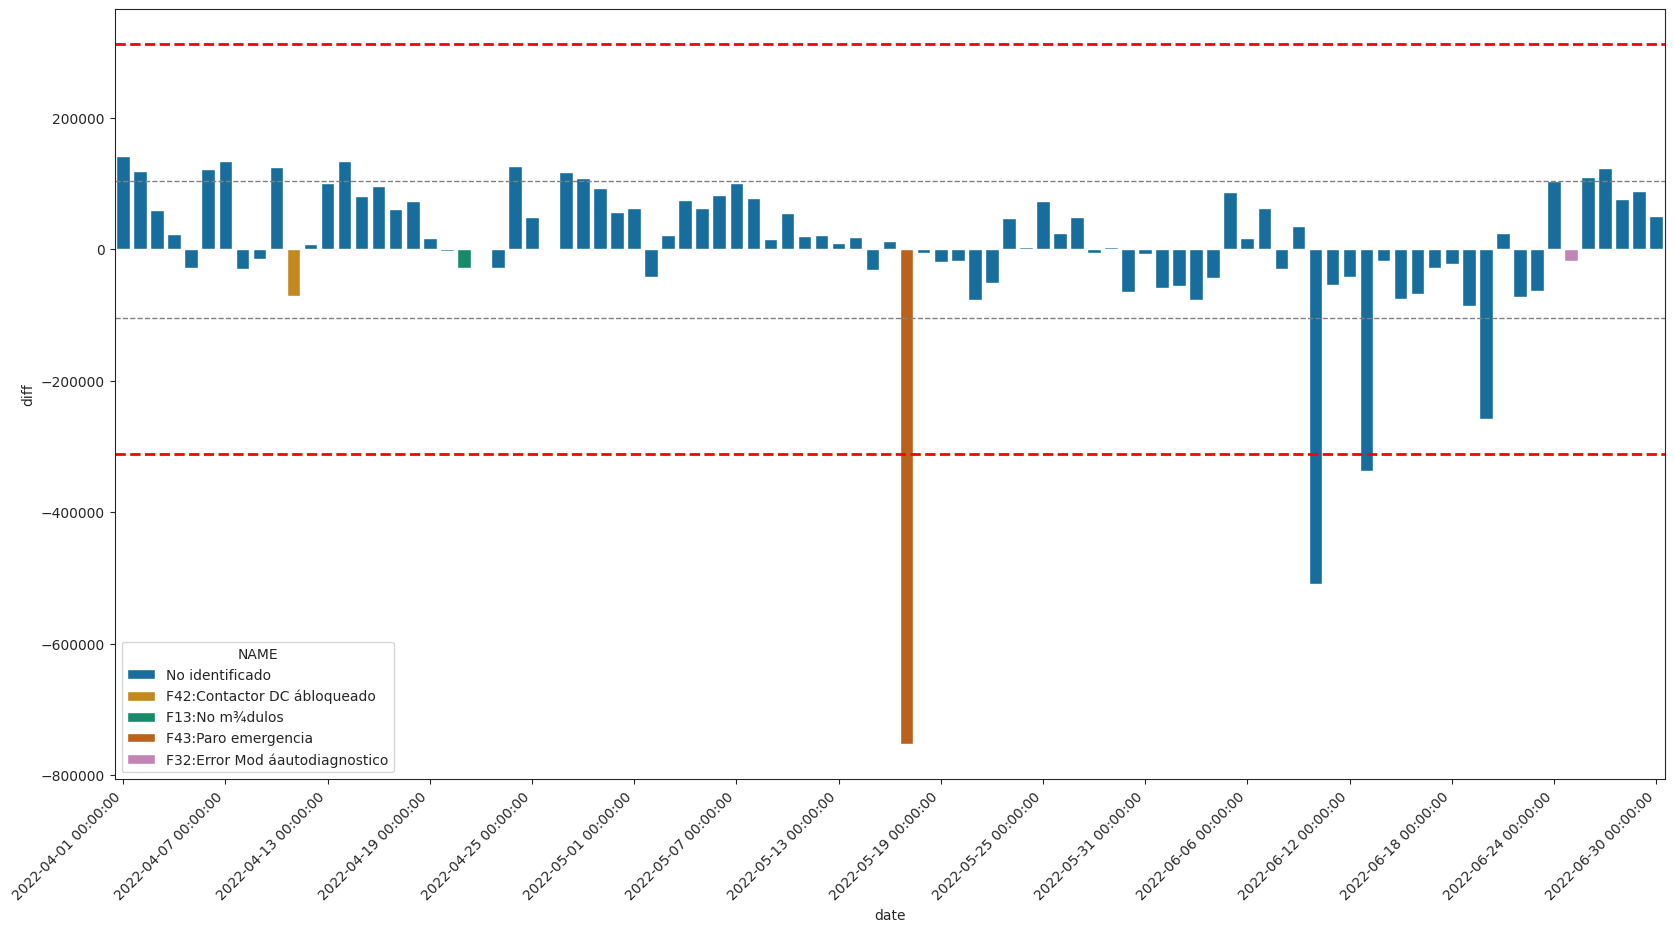

In [69]:
import seaborn as sns

# Set the style to have a smooth vertical grid
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(20, 10))
daily_fallos_df["NAME"] = daily_fallos_df["NAME"].fillna("No identificado")
filtered_df = daily_fallos_df[((daily_fallos_df["datetime_utc"].dt.month == 4) |
                               (daily_fallos_df["datetime_utc"].dt.month == 5) |
                               (daily_fallos_df["datetime_utc"].dt.month == 6)) &
                             (daily_fallos_df["datetime_utc"].dt.year == 2022)].drop_duplicates(subset = ["date", "NAME"])
sns.barplot(filtered_df, 
            x="date", 
            y="diff", 
            hue="NAME",
            ax=ax,
            dodge = False,
            palette = "colorblind")

# Set the x-axis labels to display every week
ax.xaxis.set_major_locator(plt.MaxNLocator(filtered_df.shape[0]//5))
plt.xticks(rotation=45, ha='right')

# Add horizontal dashed lines at +- lower_lim
ax.axhline(y=-lower_lim, linestyle='--', color='gray', linewidth=1)
ax.axhline(y=lower_lim, linestyle='--', color='gray', linewidth=1)

# Add thicker red dashed lines at +- upper_lim
ax.axhline(y=-upper_lim, linestyle='--', color='red', linewidth=2)
ax.axhline(y=upper_lim, linestyle='--', color='red', linewidth=2)

plt.show()

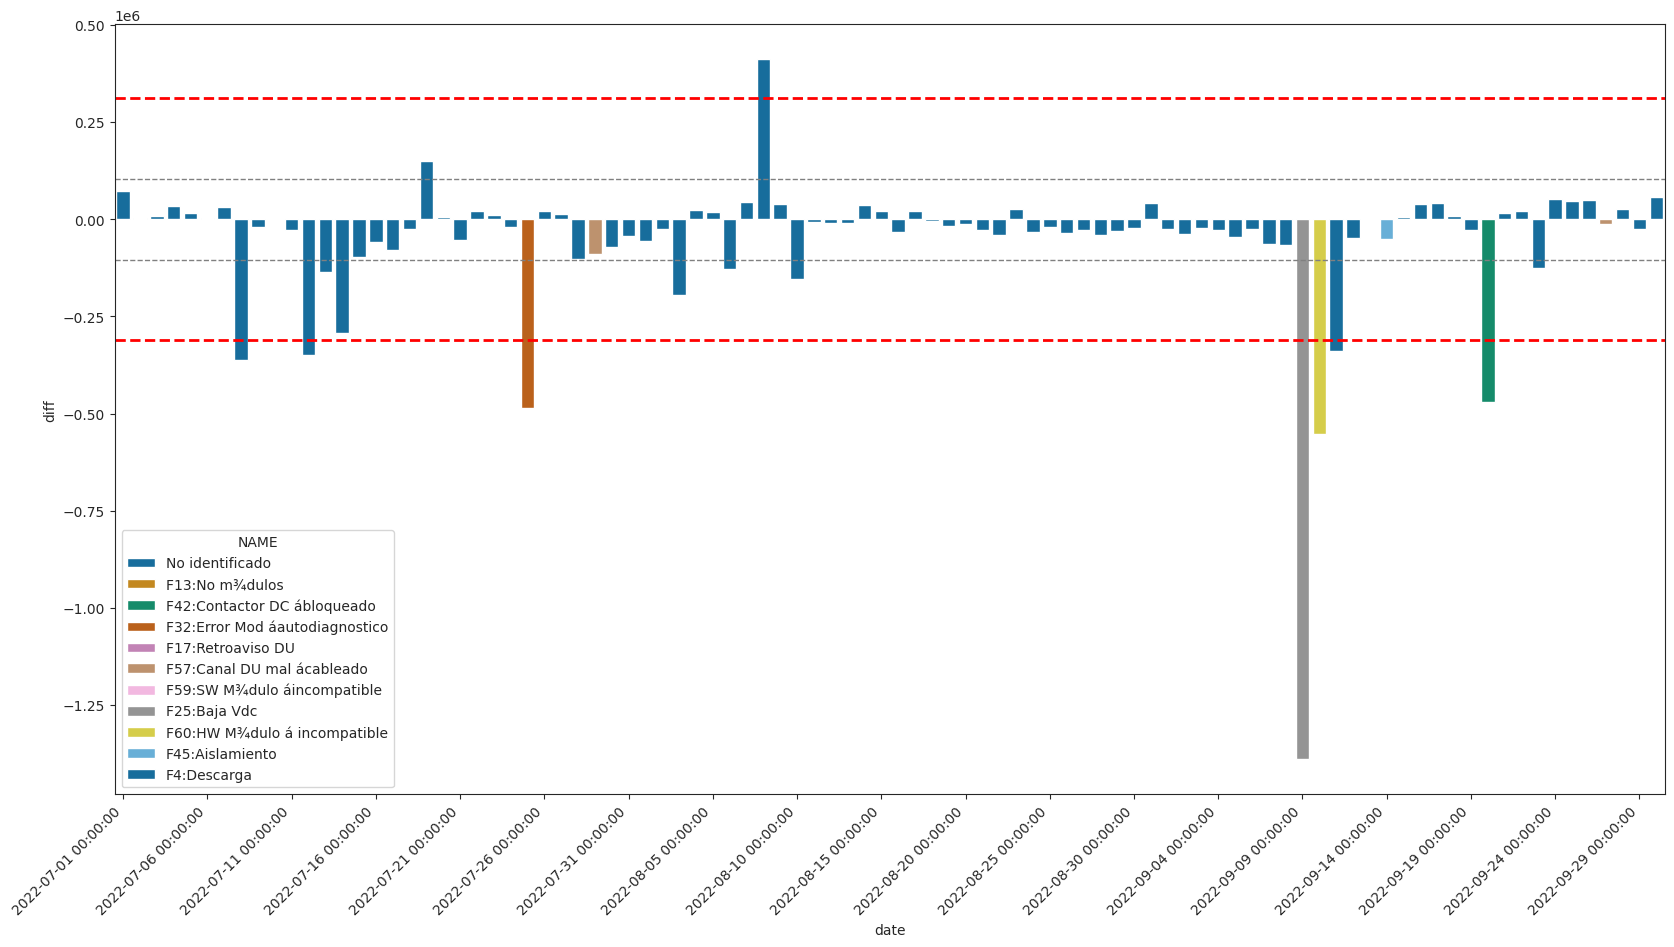

In [68]:
import seaborn as sns

# Set the style to have a smooth vertical grid
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(20, 10))
daily_fallos_df["NAME"] = daily_fallos_df["NAME"].fillna("No identificado")
filtered_df = daily_fallos_df[((daily_fallos_df["datetime_utc"].dt.month == 7) |
                               (daily_fallos_df["datetime_utc"].dt.month == 8) |
                               (daily_fallos_df["datetime_utc"].dt.month == 9)) &
                             (daily_fallos_df["datetime_utc"].dt.year == 2022)].drop_duplicates(subset = ["date", "NAME"])
sns.barplot(filtered_df, 
            x="date", 
            y="diff", 
            hue="NAME",
            ax=ax,
            dodge = False,
            palette = "colorblind")

# Set the x-axis labels to display every week
ax.xaxis.set_major_locator(plt.MaxNLocator(filtered_df.shape[0]//5))
plt.xticks(rotation=45, ha='right')

# Add horizontal dashed lines at +- lower_lim
ax.axhline(y=-lower_lim, linestyle='--', color='gray', linewidth=1)
ax.axhline(y=lower_lim, linestyle='--', color='gray', linewidth=1)

# Add thicker red dashed lines at +- upper_lim
ax.axhline(y=-upper_lim, linestyle='--', color='red', linewidth=2)
ax.axhline(y=upper_lim, linestyle='--', color='red', linewidth=2)

plt.show()

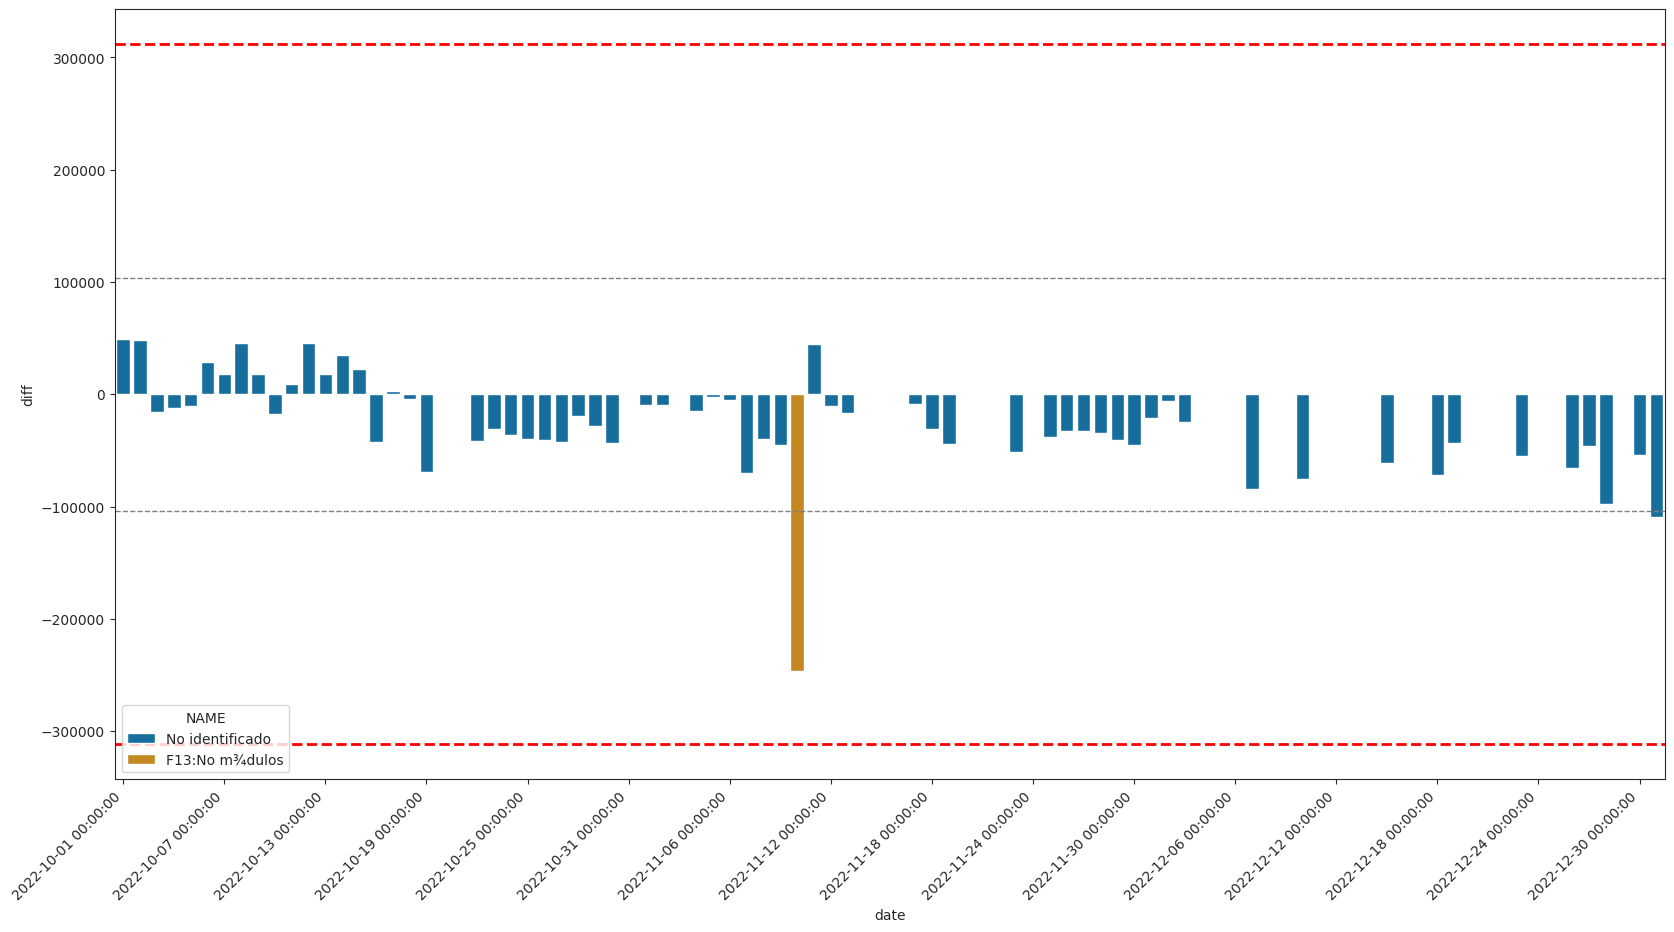

In [71]:
import seaborn as sns

# Set the style to have a smooth vertical grid
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(20, 10))
daily_fallos_df["NAME"] = daily_fallos_df["NAME"].fillna("No identificado")
filtered_df = daily_fallos_df[((daily_fallos_df["datetime_utc"].dt.month == 10) |
                               (daily_fallos_df["datetime_utc"].dt.month == 11) |
                               (daily_fallos_df["datetime_utc"].dt.month == 12)) &
                             (daily_fallos_df["datetime_utc"].dt.year == 2022)].drop_duplicates(subset = ["date", "NAME"])
sns.barplot(filtered_df, 
            x="date", 
            y="diff", 
            hue="NAME",
            ax=ax,
            dodge = False,
            palette = "colorblind")

# Set the x-axis labels to display every week
ax.xaxis.set_major_locator(plt.MaxNLocator(filtered_df.shape[0]//5))
plt.xticks(rotation=45, ha='right')

# Add horizontal dashed lines at +- lower_lim
ax.axhline(y=-lower_lim, linestyle='--', color='gray', linewidth=1)
ax.axhline(y=lower_lim, linestyle='--', color='gray', linewidth=1)

# Add thicker red dashed lines at +- upper_lim
ax.axhline(y=-upper_lim, linestyle='--', color='red', linewidth=2)
ax.axhline(y=upper_lim, linestyle='--', color='red', linewidth=2)

plt.show()

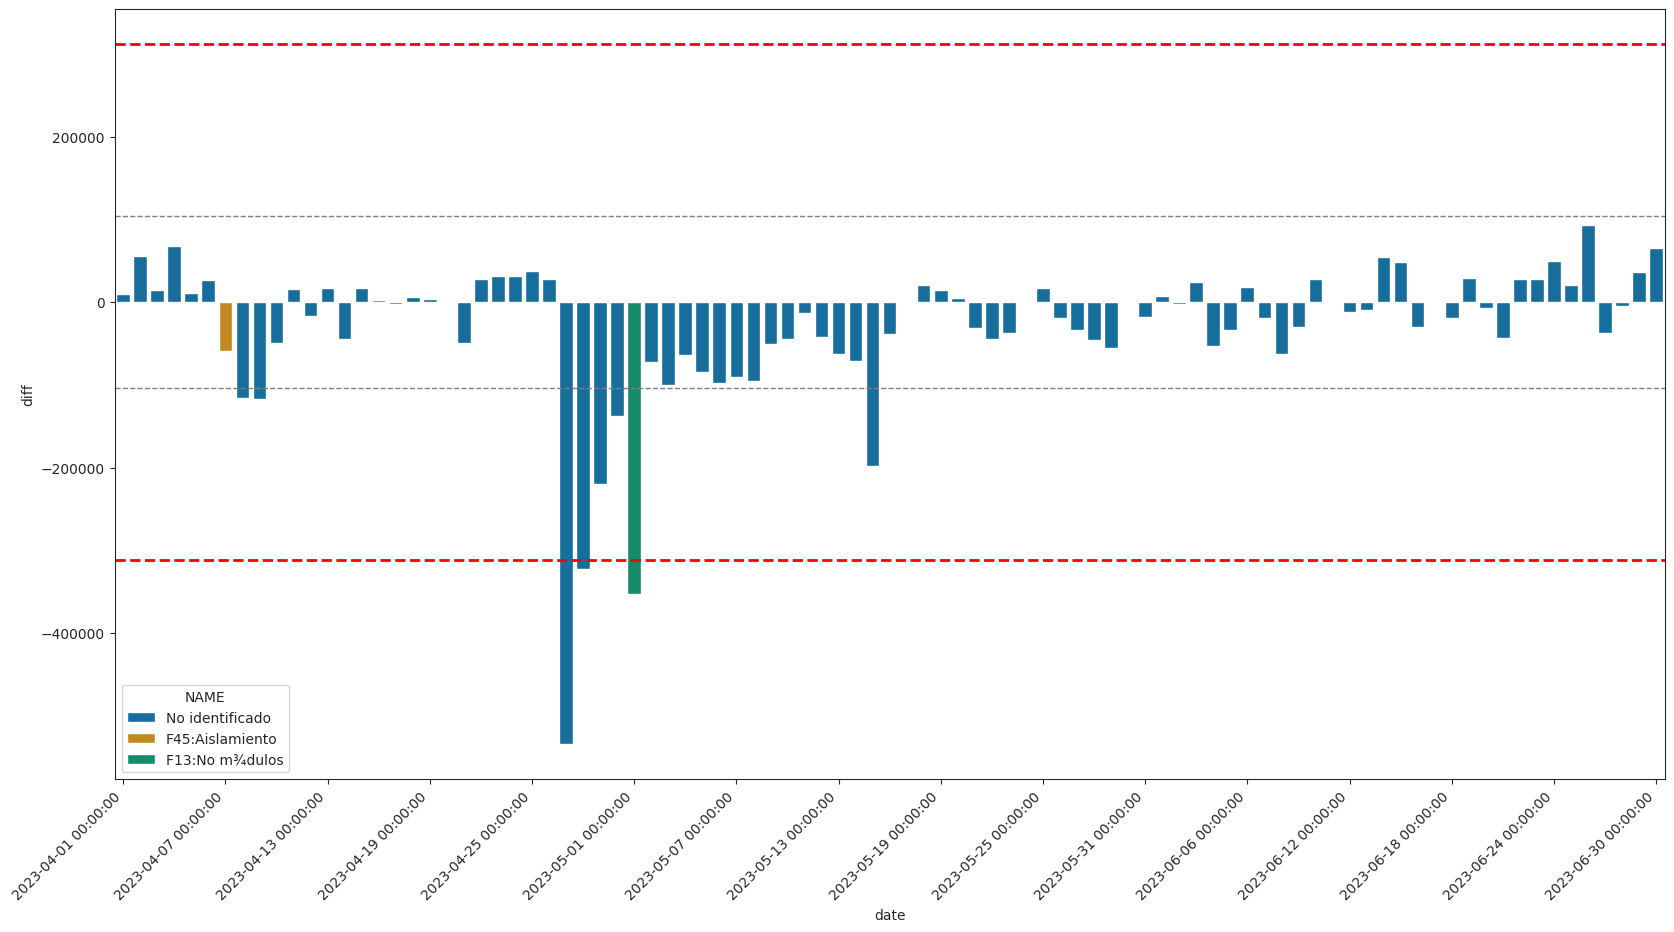

In [75]:
import seaborn as sns

# Set the style to have a smooth vertical grid
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(20, 10))
daily_fallos_df["NAME"] = daily_fallos_df["NAME"].fillna("No identificado")
filtered_df = daily_fallos_df[((daily_fallos_df["datetime_utc"].dt.month == 4) |
                               (daily_fallos_df["datetime_utc"].dt.month == 5) |
                               (daily_fallos_df["datetime_utc"].dt.month == 6)) &
                             (daily_fallos_df["datetime_utc"].dt.year == 2023)].drop_duplicates(subset = ["date", "NAME"])
sns.barplot(filtered_df, 
            x="date", 
            y="diff", 
            hue="NAME",
            ax=ax,
            dodge = False,
            palette = "colorblind")

# Set the x-axis labels to display every week
ax.xaxis.set_major_locator(plt.MaxNLocator(filtered_df.shape[0]//5))
plt.xticks(rotation=45, ha='right')

# Add horizontal dashed lines at +- lower_lim
ax.axhline(y=-lower_lim, linestyle='--', color='gray', linewidth=1)
ax.axhline(y=lower_lim, linestyle='--', color='gray', linewidth=1)

# Add thicker red dashed lines at +- upper_lim
ax.axhline(y=-upper_lim, linestyle='--', color='red', linewidth=2)
ax.axhline(y=upper_lim, linestyle='--', color='red', linewidth=2)

plt.show()

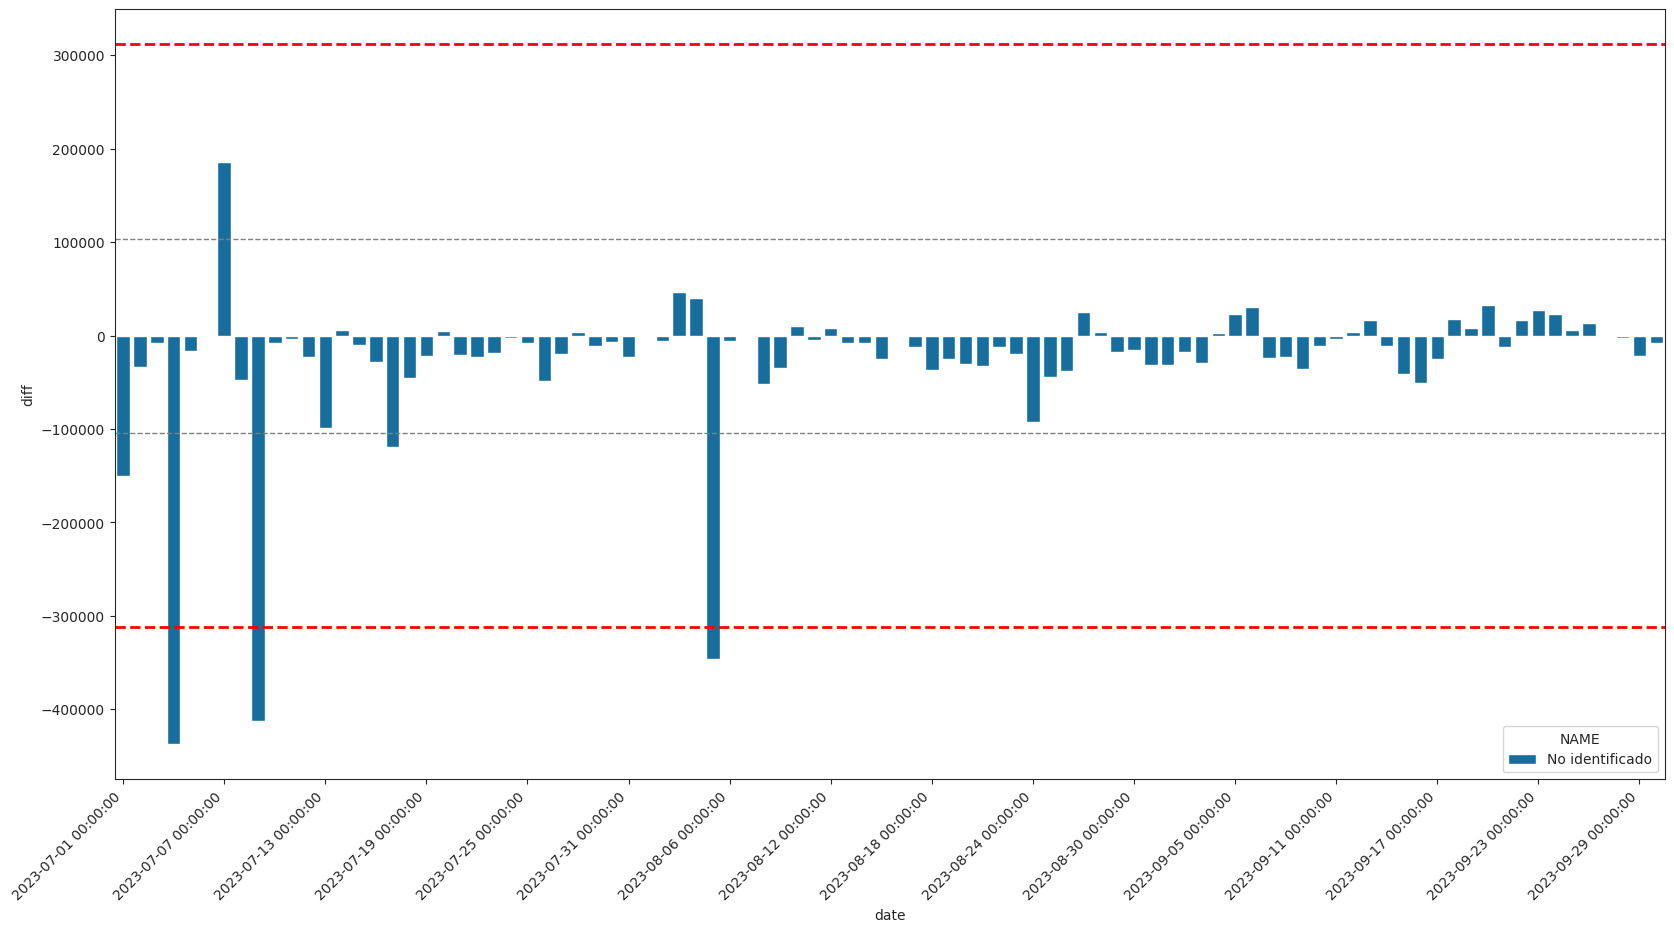

In [76]:
import seaborn as sns

# Set the style to have a smooth vertical grid
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(20, 10))
daily_fallos_df["NAME"] = daily_fallos_df["NAME"].fillna("No identificado")
filtered_df = daily_fallos_df[((daily_fallos_df["datetime_utc"].dt.month == 7) |
                               (daily_fallos_df["datetime_utc"].dt.month == 8) |
                               (daily_fallos_df["datetime_utc"].dt.month == 9)) &
                             (daily_fallos_df["datetime_utc"].dt.year == 2023)].drop_duplicates(subset = ["date", "NAME"])
sns.barplot(filtered_df, 
            x="date", 
            y="diff", 
            hue="NAME",
            ax=ax,
            dodge = False,
            palette = "colorblind")

# Set the x-axis labels to display every week
ax.xaxis.set_major_locator(plt.MaxNLocator(filtered_df.shape[0]//5))
plt.xticks(rotation=45, ha='right')

# Add horizontal dashed lines at +- lower_lim
ax.axhline(y=-lower_lim, linestyle='--', color='gray', linewidth=1)
ax.axhline(y=lower_lim, linestyle='--', color='gray', linewidth=1)

# Add thicker red dashed lines at +- upper_lim
ax.axhline(y=-upper_lim, linestyle='--', color='red', linewidth=2)
ax.axhline(y=upper_lim, linestyle='--', color='red', linewidth=2)

plt.show()